In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import importlib
import utils
import attention
import glob
from collections import defaultdict

import seaborn as sns
import pandas as pd

# Number of Parameters in Each Model

In [25]:

outdir = "/scratch/gpfs/qanguyen/renorm"
arches = ["mlp", "cnn", "cnn_chan_1-16", "cnn_chan_1-1", "alexnet", "vgg11", "attn", "attn_no_pe"]
for arch in arches:
    for f in glob.glob(f"{outdir}/{arch}_shuffled_True*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        shapes = [v.ravel().shape for p, v in record["model"]]
        print(arch, torch.sum(torch.tensor(shapes)))

mlp tensor(328510)
cnn tensor(62006)
cnn_chan_1-16 tensor(59626)
cnn_chan_1-1 tensor(14236)
alexnet tensor(57044810)
vgg11 tensor(128807306)
attn tensor(8458250)
attn_no_pe tensor(8458250)


# Train & Test Loss, Accuracy

Number of runs alexnet True 1
Number of runs alexnet False 1
[3.21698040263668] 1
[1.8926814430078882] 1


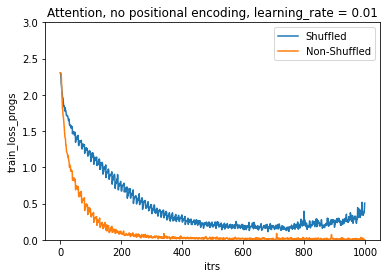

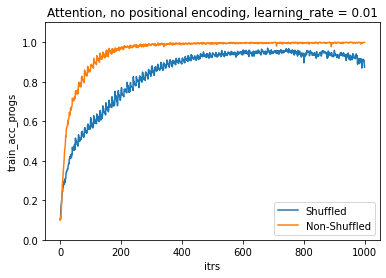

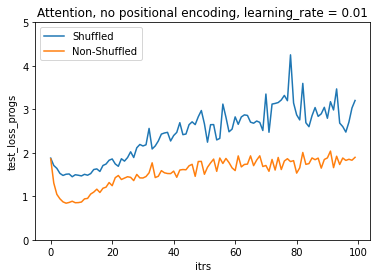

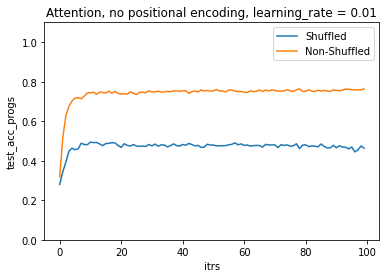

model_True_test_losses [3.21698040263668]
model_False_test_losses [1.8926814430078882]


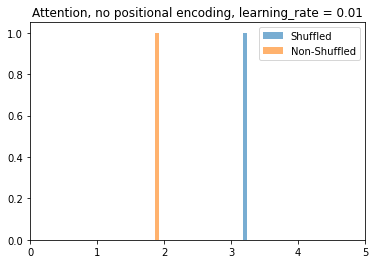

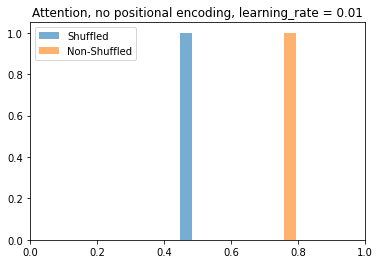

In [2]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    #outdir = "/scratch/gpfs/qanguyen/renorm"
    outdir = "/gpfs/milgram/scratch60/turk-browne/an633/renorm_quench"
    test_losses = []
    test_accs = []
    lrs = []
    itrs = []
    train_loss_progs = []
    train_acc_progs = []
    testlosses_dict = []
    
    test_itrs = []
    test_loss_progs = []
    test_acc_progs = []
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        itr, train_loss_prog = list(zip(*enumerate(record["metrics"]["train_loss_prog"])))
        if len(itr) > 500:
            test_losses.append(record["metrics"]["test_loss"])
            test_accs.append(record["metrics"]["test_accuracy"])
            itrs.extend(itr)
            train_loss_progs.extend(train_loss_prog)
            testlosses_dict.extend([record["metrics"]["test_loss"]] * len(itr))
            
        itr, train_acc_prog = list(zip(*enumerate(record["metrics"]["train_acc_prog"])))
        if len(itr) > 500:
            train_acc_progs.extend(train_acc_prog)
            
        itr, test_loss_prog = list(zip(*enumerate(record["metrics"]["test_loss_prog"])))
        test_itrs.extend(itr)
        test_loss_progs.extend(test_loss_prog)
        
        itr, test_acc_prog = list(zip(*enumerate(record["metrics"]["test_acc_prog"])))
        test_acc_progs.extend(test_acc_prog)
        
    print("Number of runs", model_name, shuffled, len(test_losses))
    train_df = pd.DataFrame.from_dict(dict(itrs = itrs, 
                                                         train_loss_progs = train_loss_progs, 
                                                         train_acc_progs = train_acc_progs,
                                                         testlosses_dict = testlosses_dict))
    test_df = pd.DataFrame.from_dict(dict(itrs = test_itrs, 
                                                         test_loss_progs = test_loss_progs, 
                                                         test_acc_progs = test_acc_progs))
    return test_losses, test_accs, lrs, train_df, test_df
    
    
def plot(model_name, title, extra=""):
    model_True_test_losses, model_True_test_accs, _, shuffletrainloss, shuffletestloss  = get_record(model_name = model_name, shuffled = "True", extra = extra)
    model_False_test_losses, model_False_test_accs, _, non_shuffletrainloss, non_shuffletestloss = get_record(model_name = model_name, shuffled = "False", extra = extra)
    model_True_test_losses = [i for i in model_True_test_losses if not np.isnan(i)]
    
    #model_True_test_losses = [i for i in model_True_test_losses if i < np.sort(model_True_test_losses)[-1]]
    #model_False_test_losses = [i for i in model_False_test_losses if i < np.sort(model_False_test_losses)[-1]]
    print(model_True_test_losses, len(model_True_test_losses))
    print(model_False_test_losses, len(model_False_test_losses))

    sns.lineplot(x = "itrs", y="train_loss_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_loss_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 3)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="train_acc_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_acc_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
                                     
    sns.lineplot(x = "itrs", y="test_loss_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_loss_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 5)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="test_acc_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_acc_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
    
    print("model_True_test_losses", model_True_test_losses)
    print("model_False_test_losses", model_False_test_losses)
    plt.hist(model_True_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 5)
    plt.title(title)
    plt.legend()
    plt.show()
    

    plt.hist(model_True_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 1)
    plt.title(title)
    plt.legend()
    plt.show()

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

plot("alexnet", title = "Attention, no positional encoding, learning_rate = 0.01", extra="lr_0.01")

# plot("vgg11", title = "VGG, learning_rate = 0.001", extra="lr_0.001")

# plot("vgg11", title = "VGG, learning_rate = 0.01", extra="lr_0.01")

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

# plot("attn_no_pe", title = "Attention, no positional encoding")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels")

# plot("mlp", title = "MLP", extra="lr_0.001")

# plot("mlp", title = "MLP", extra="lr_0.01")


## Holding the shuffle permutation fixed

[[[0.4496173  0.52663434 0.47668734]
  [0.54987353 0.55575544 0.5160403 ]
  [0.49554032 0.5608506  0.5492583 ]
  [0.5134214  0.52657974 0.4315286 ]
  [0.43549526 0.510604   0.5265976 ]
  [0.55574983 0.48856792 0.45850074]
  [0.5135425  0.48764232 0.46054152]
  [0.46217045 0.52114636 0.46102372]
  [0.5325329  0.5497944  0.5467843 ]
  [0.5329117  0.5293136  0.46599266]
  [0.504152   0.5038543  0.47570086]]

 [[0.5091302  0.50606674 0.55340743]
  [0.5502989  0.5440201  0.5395487 ]
  [0.53897417 0.5202846  0.4036138 ]
  [0.5355207  0.44556168 0.5176998 ]
  [0.48846766 0.5544489  0.5427135 ]
  [0.5677274  0.53840053 0.47507572]
  [0.45627674 0.4762116  0.4716182 ]
  [0.47201705 0.46289653 0.49129343]
  [0.54394644 0.5046541  0.46903798]
  [0.5069712  0.5397295  0.5476844 ]
  [0.49559498 0.5559115  0.5402565 ]]

 [[0.5109227  0.5133579  0.49632737]
  [0.481006   0.4987156  0.5582062 ]
  [0.5232589  0.5462615  0.4835016 ]
  [0.41105163 0.46870846 0.48534986]
  [0.5309055  0.5225289  0.5383739

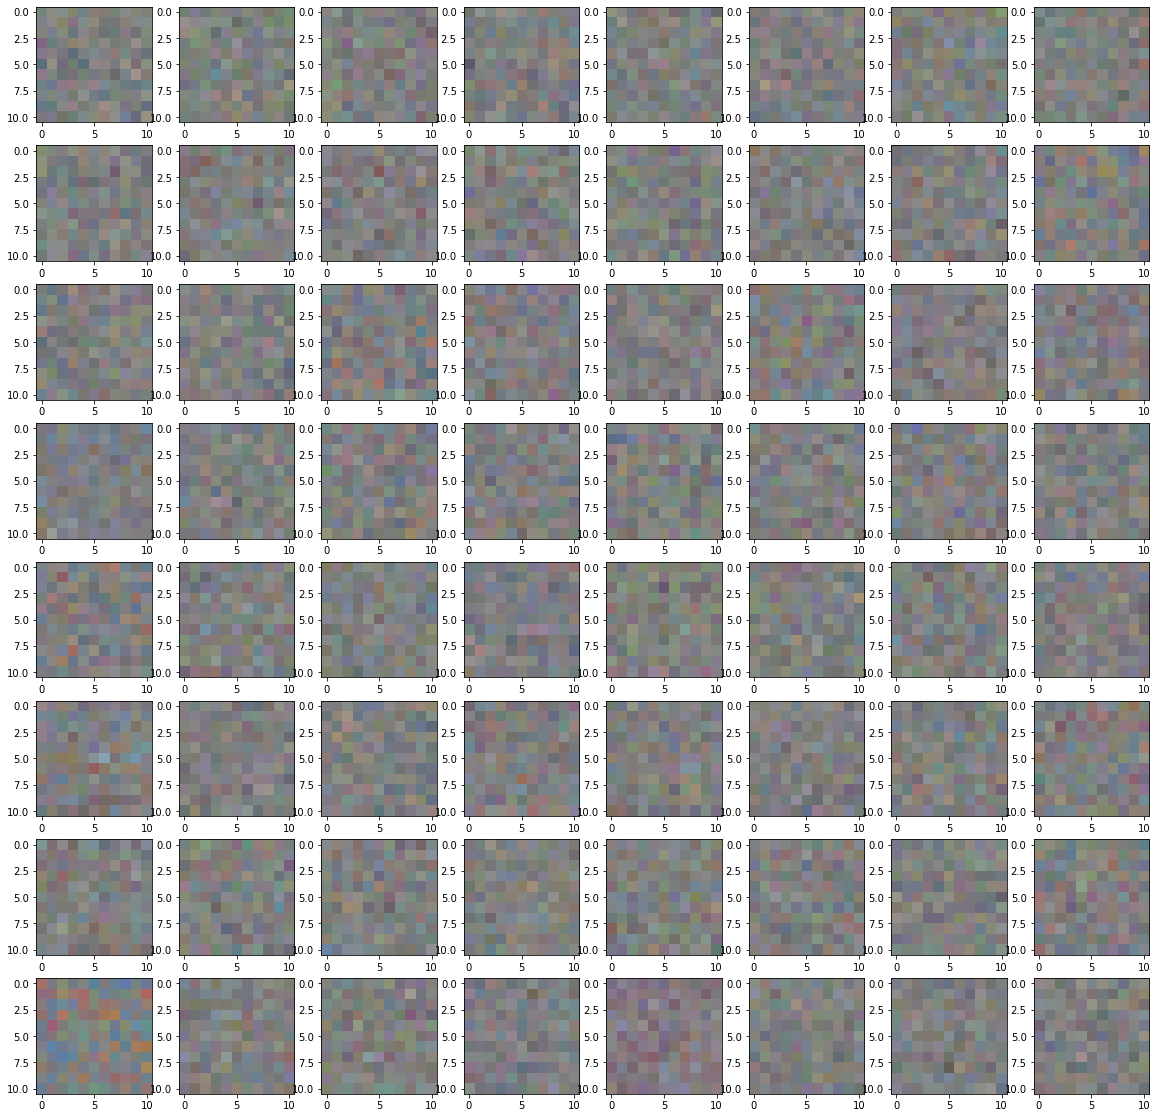

NameError: name 'model' is not defined

In [16]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    #outdir = "/scratch/gpfs/qanguyen/renorm"
    outdir = "/gpfs/milgram/scratch60/turk-browne/an633/renorm_quench"
    
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:2]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            if _ == 0:
                print(v)
            plt.imshow(v)
            #pars[_].append(v)
        plt.show()
        
        print(model)
        break
get_record("alexnet", shuffled=True)

# Average the filters for different quenched transformations 


In [ ]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    import warnings
    warnings.filterwarnings("ignore")
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:200]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}
        param_dict['conv1.weight'] = param_dict['conv1.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        #plt.figure(figsize=(10,5))
        for _ in range(6):
            #plt.subplot(1, 6, _+1)
            v = param_dict['conv1.weight'][_].detach().cpu().numpy()
            #plt.imshow(v)
            pars[_].append(v)
        #print(param_dict['conv1.weight'])
        #plt.show()
    plt.figure(figsize=(10,5))
    i = 1
    stds = []
    for _, convs in pars.items():
        plt.subplot(1, 6, i)
        m = torch.tensor(convs).mean(dim=0)
        s = torch.tensor(convs).std(dim=0)
        #print(m)
        plt.imshow(m,vmin=0,vmax=1)
        i += 1
        stds.extend(s.numpy().ravel())
    plt.show()
    plt.hist(stds)
    plt.xlim(0.1, 0.9)
    plt.show()

get_record(model_name = "cnn", shuffled=True)
get_record(model_name = "cnn", shuffled=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

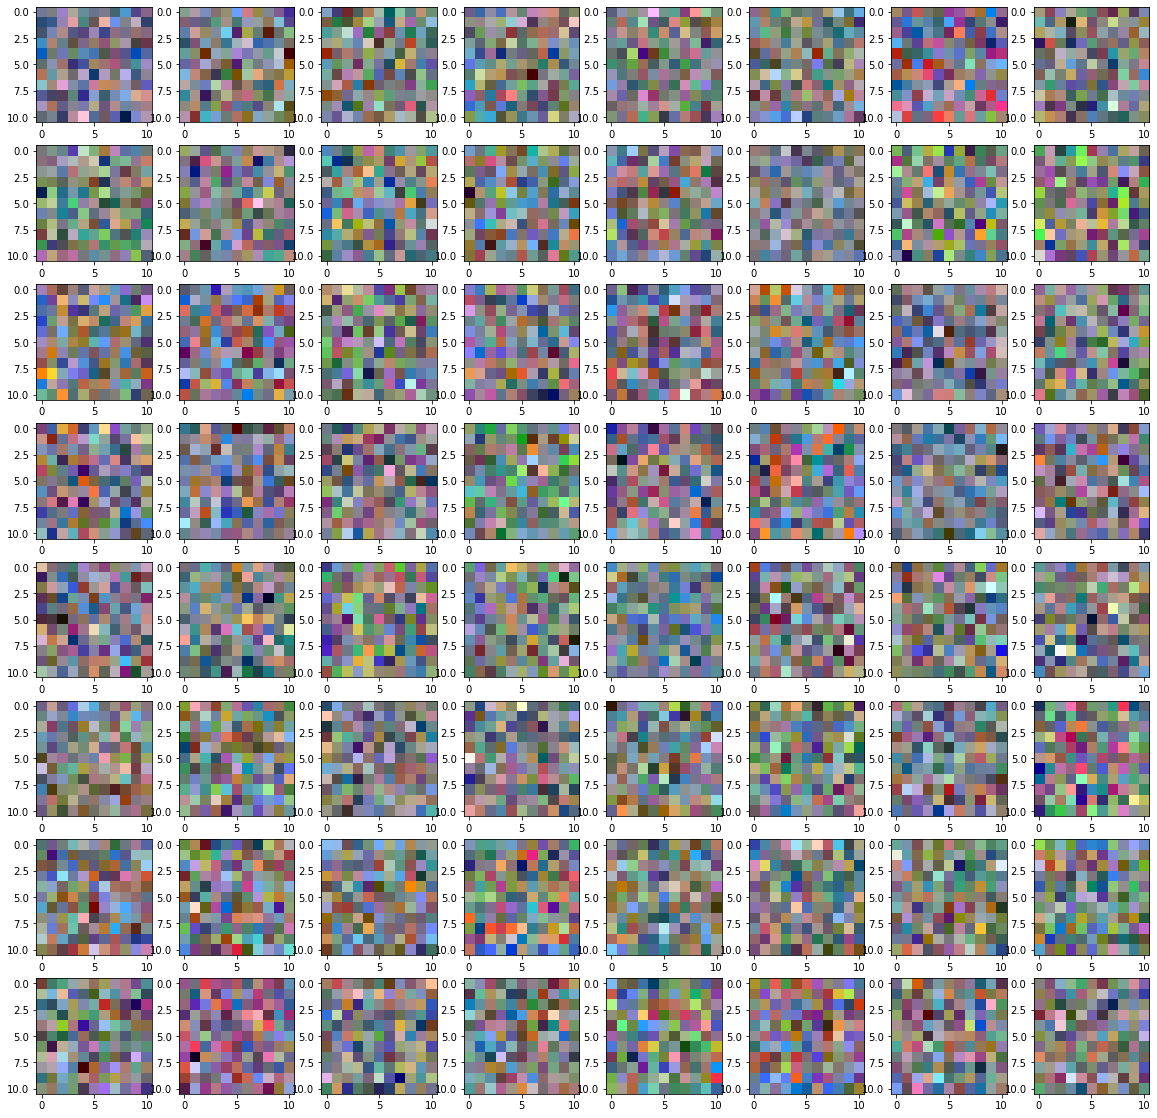

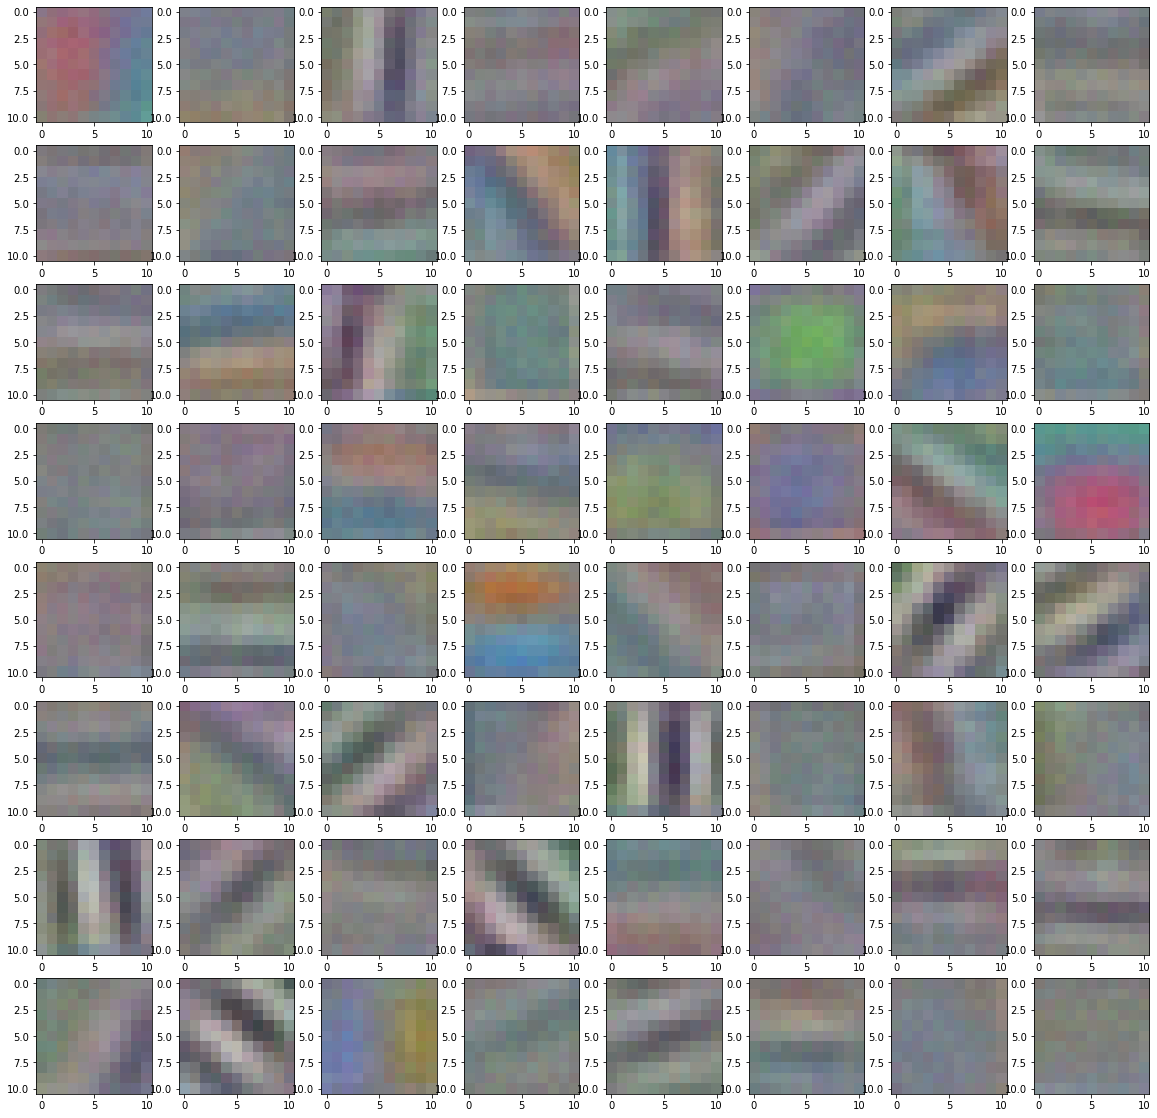

In [66]:
importlib.reload(utils)
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            plt.imshow(v)
            pars[_].append(v)
        plt.show()
import warnings

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)

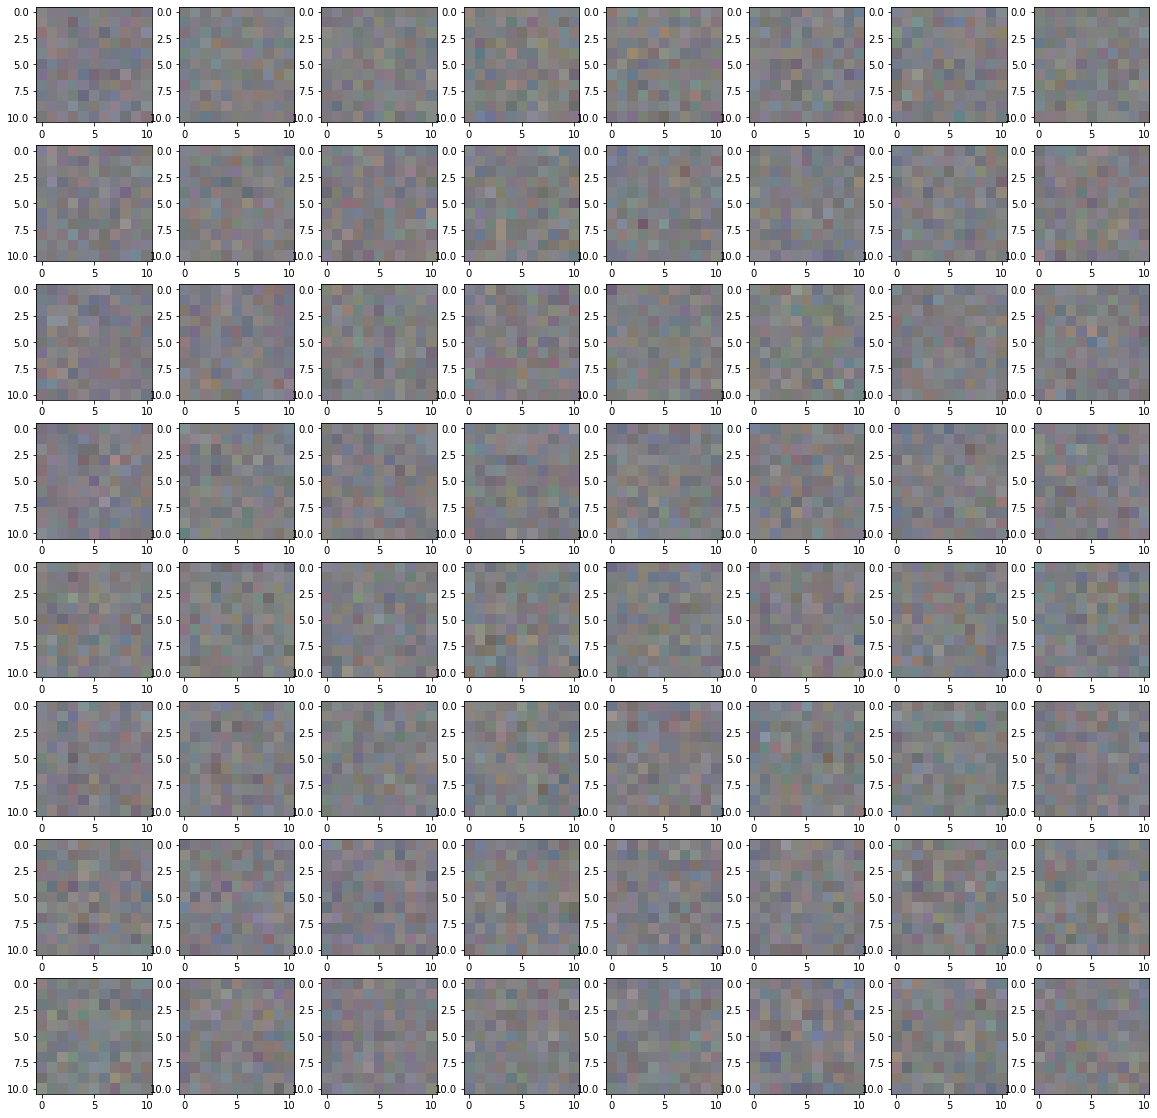

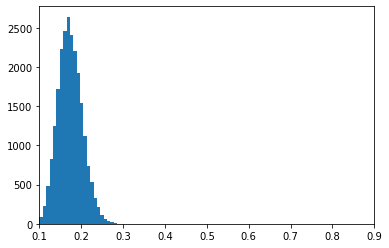

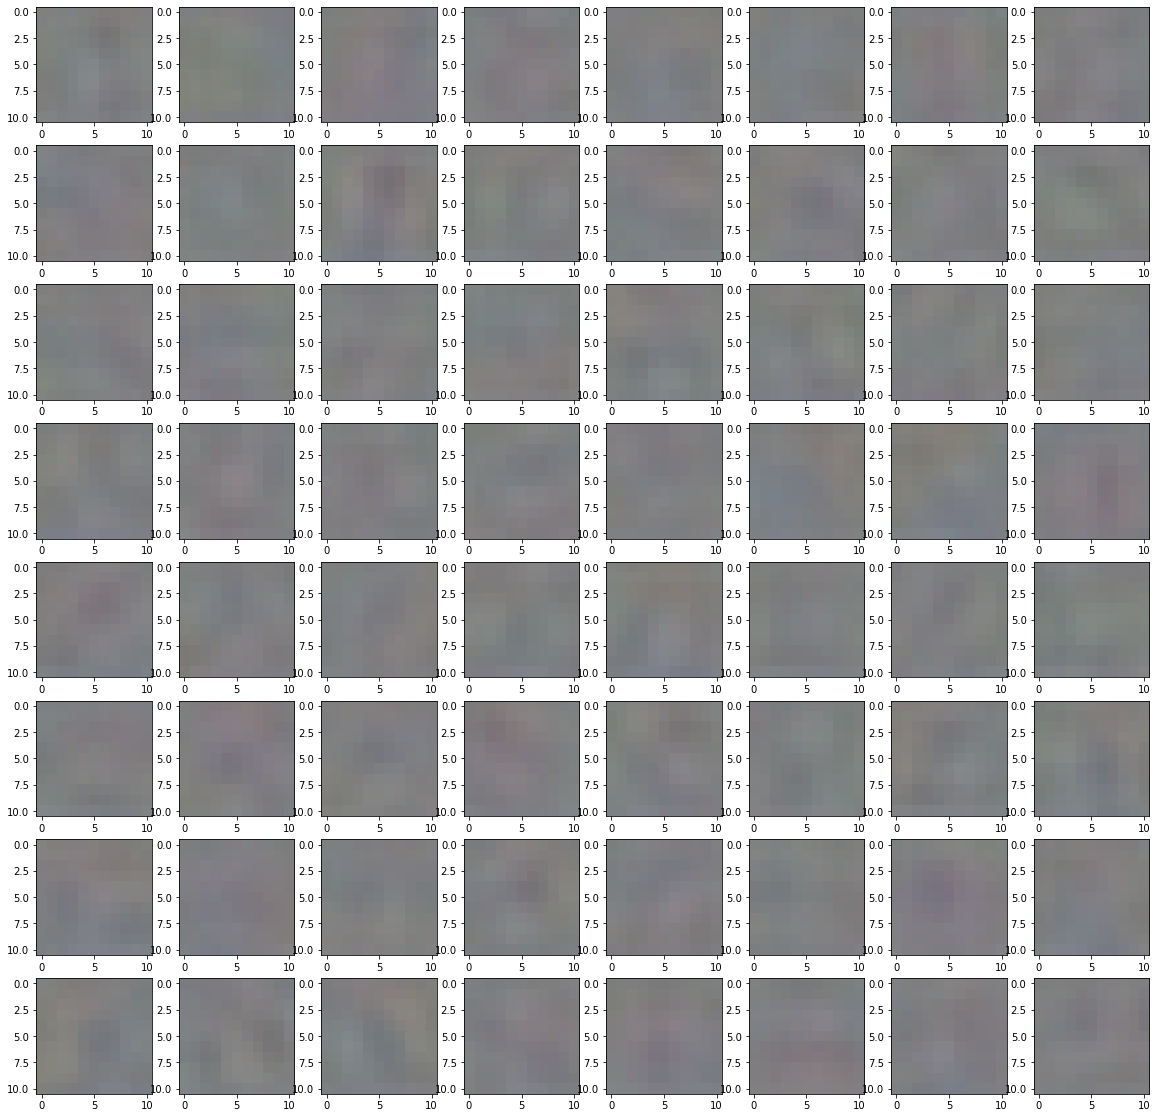

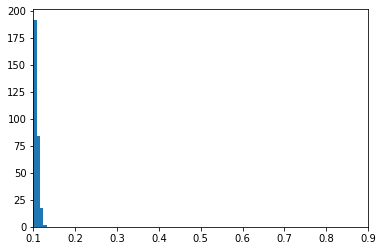

In [72]:
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    import warnings
    warnings.filterwarnings("ignore")
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:200]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        for _ in range(64):
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            pars[_].append(v)
    plt.figure(figsize=(20,20))
    i = 1
    stds = []
    for _, convs in pars.items():
        plt.subplot(8, 8, i)
        m = torch.tensor(convs).mean(dim=0)
        s = torch.tensor(convs).std(dim=0)
        #print(m)
        plt.imshow(m,vmin=0,vmax=1)
        i += 1
        stds.extend(s.numpy().ravel())
    plt.show()
    plt.hist(stds,bins=np.linspace(0.1,0.9,100))
    plt.xlim(0.1, 0.9)
    plt.show()

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)

# Hold quenched transform fixed and run multiple runs on that transformation

In [6]:
importlib.reload(utils)
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*"):
        record = utils.load_file_pickle(f)
        print(record)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            plt.imshow(v)
            pars[_].append(v)
        plt.show()
import warnings

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)a

SyntaxError: invalid syntax (3481618575.py, line 23)

# Polynomial Regression

## Models (MLP_small, resnetsmall)

{'num_examples': 50000, 'num_inputs': 12, 'order': 3, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_3_numinputs_12_numexamples_50000_is_online_False_rep_1661775310.726328.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 20, 'order': 3, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1661762050.358074.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 8, 'order': 3, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1661775132.105783.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 2, 'order': 3, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_or

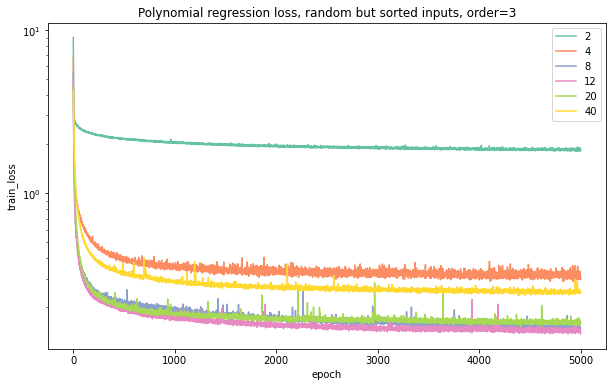

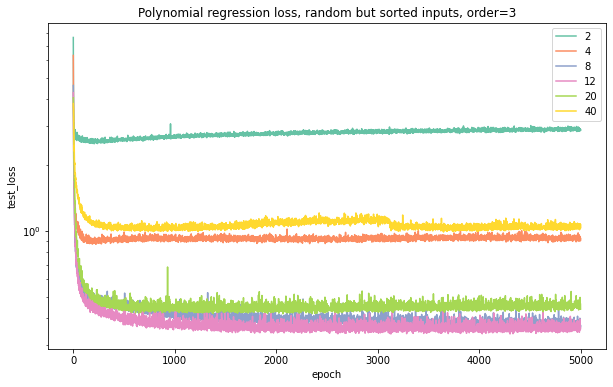

{'num_examples': 50000, 'num_inputs': 40, 'order': 5, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_5_numinputs_40_numexamples_50000_is_online_False_rep_1661771896.873102.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 40, 'order': 5, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_5_numinputs_40_numexamples_50000_is_online_False_rep_1661778855.066987.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 4, 'order': 5, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_5_numinputs_4_numexamples_50000_is_online_False_rep_1661763832.505478.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 12, 'order': 5, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_o

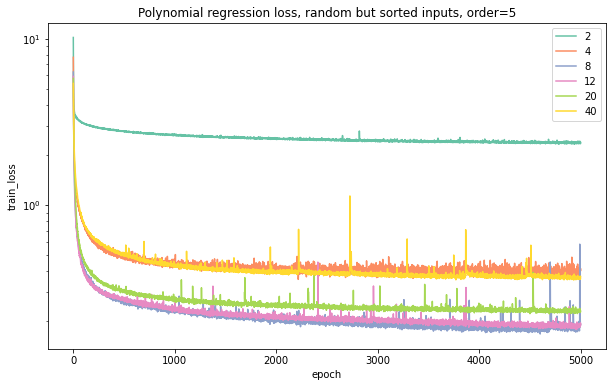

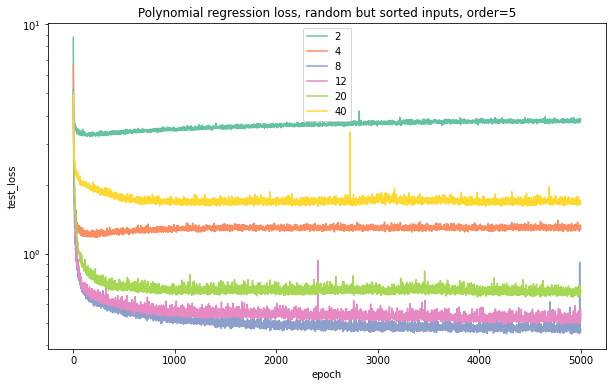

{'num_examples': 50000, 'num_inputs': 20, 'order': 10, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_10_numinputs_20_numexamples_50000_is_online_False_rep_1661795066.488402.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 4, 'order': 10, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_10_numinputs_4_numexamples_50000_is_online_False_rep_1661780448.585716.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 8, 'order': 10, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_order_10_numinputs_8_numexamples_50000_is_online_False_rep_1661780093.942639.pkl noise 0.0
{'num_examples': 50000, 'num_inputs': 20, 'order': 10, 'random_coefs': True, 'input_strategy': 'random', 'is_online': False, 'noise': 0.0}
/scratch/gpfs/qanguyen/poly_fix_x/mlp_sm

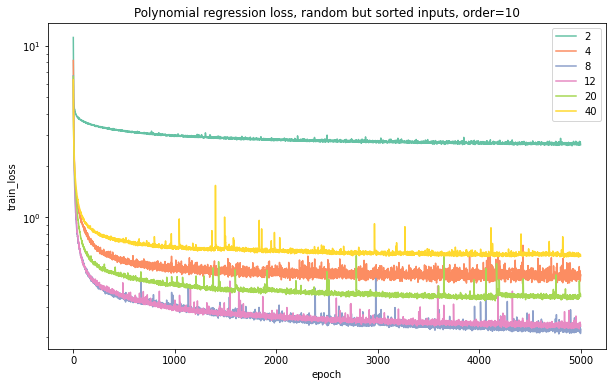

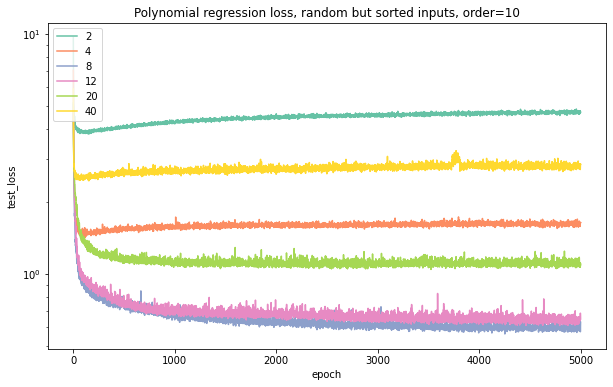

In [15]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        print(record["data_params"])
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = 3, input_strategy_list=["random"], is_online=False, title = "Polynomial regression loss, random but sorted inputs, order=3", num_inputs_list=[2, 4,8,12,20, 40, 60], outdir = "/scratch/gpfs/qanguyen/poly_fix_x")
get_record(model_name = "mlp_small", order = 5, input_strategy_list=["random"], is_online=False, title = "Polynomial regression loss, random but sorted inputs, order=5", num_inputs_list=[2, 4,8,12,20, 40, 60], outdir = "/scratch/gpfs/qanguyen/poly_fix_x")
get_record(model_name = "mlp_small", order = 10, input_strategy_list=["random"], is_online=False, title = "Polynomial regression loss, random but sorted inputs, order=10", num_inputs_list=[2, 4,8,12,20, 40, 60], outdir = "/scratch/gpfs/qanguyen/poly_fix_x")
# get_record(model_name = "mlp_small", order = 5, is_online=False, title = "Polynomial regression loss, order=5", order_list=[2, 4,8,12,20, 40, 60])
# get_record(model_name = "mlp_small", order = 10, is_online=False, title = "Polynomial regression loss, order=10", order_list=[2, 4,8,12,20, 40, 60])

/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1661200213.831126.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1661200328.590672.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1661200206.905655.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1661200210.169733.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_2_numinputs_40_numexamples_50000_is_online_False_rep_1661200217.718765.pkl noise 0.0


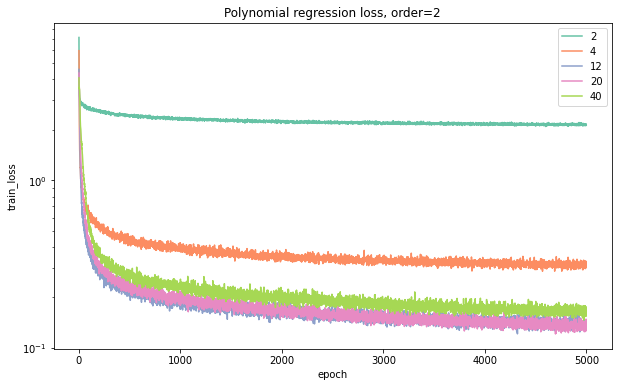

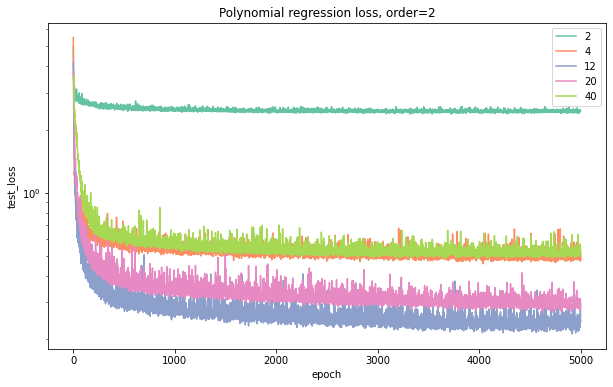

/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_3_numinputs_40_numexamples_50000_is_online_False_rep_1661200234.466282.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1661200227.945014.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1661200301.837968.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_3_numinputs_12_numexamples_50000_is_online_False_rep_1661200230.990024.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1661200236.958459.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_norm/mlp_small_batchnorm_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1661200222.254276.pkl noise 0.0


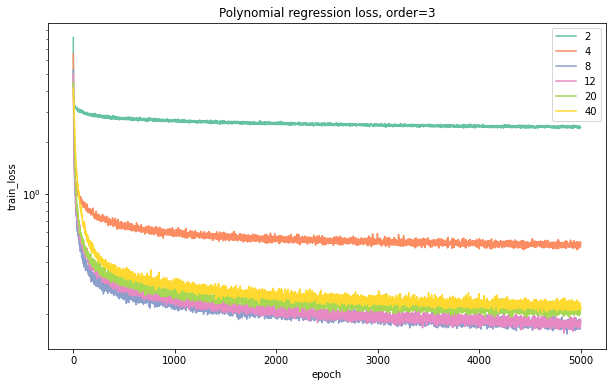

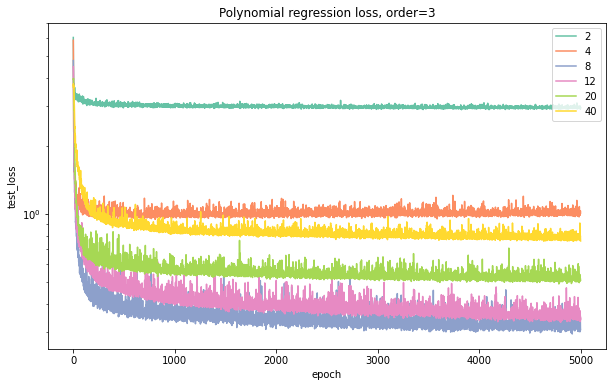

In [21]:
get_record(model_name = "mlp_small_batchnorm", order = 2, is_online=False, title = "Polynomial regression loss, order=2", order_list=[2, 4,8,12,20, 40, 60], outdir = "/scratch/gpfs/qanguyen/poly_norm/")
get_record(model_name = "mlp_small_batchnorm", order = 3, is_online=False, title = "Polynomial regression loss, order=3", order_list=[2, 4,8,12,20, 40, 60], outdir = "/scratch/gpfs/qanguyen/poly_norm/")

/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1660599096.398772.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_2_numinputs_8_numexamples_50000_is_online_False_rep_1660598751.385066.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1660598683.509599.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_2_numinputs_60_numexamples_50000_is_online_False_rep_1660599098.948741.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1660592448.596107.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1660592542.002574.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_2_numinputs_60_numexamples_50000_is_online_False_rep_1660606112.409758.pkl noise 0.0
/scratch/gpfs/qa

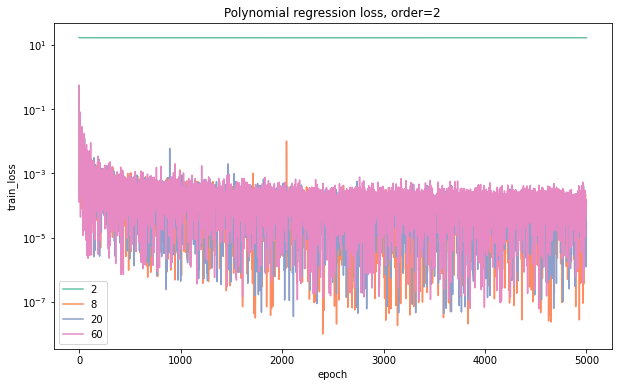

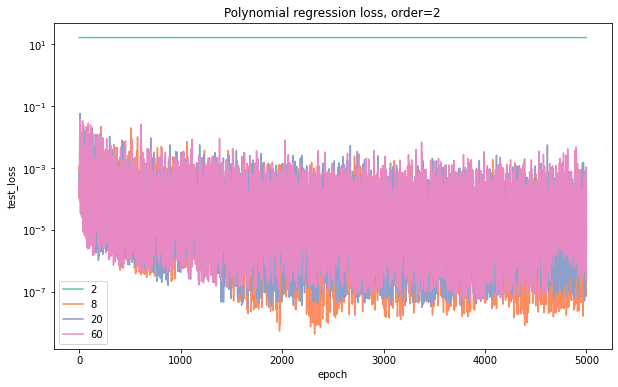

/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1660598681.643557.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660598626.896696.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660592506.923266.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660605111.676027.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660599236.442711.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1660605274.523021.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_fix_x/mlp_small_fix_x_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660606349.29983.pkl noise 0.0
/scratch/gpfs/qangu

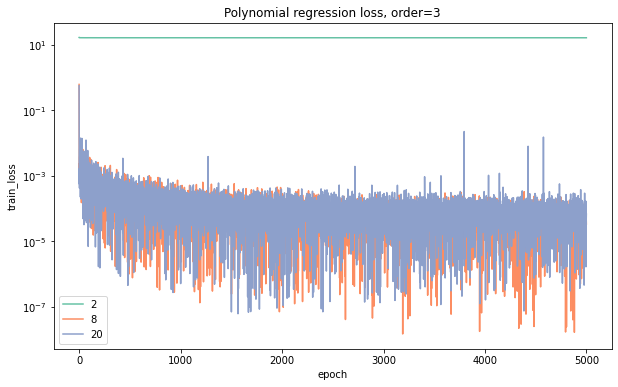

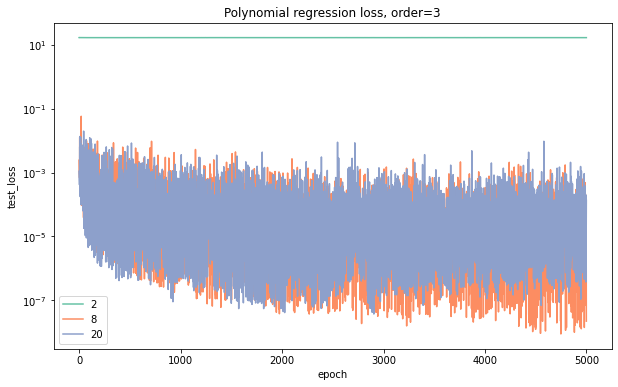

In [17]:
get_record(model_name = "mlp_small_fix_x", order = 2, is_online=False, title = "Polynomial regression loss, order=2", order_list=[2, 4,8,12,20, 40, 60], outdir = "/scratch/gpfs/qanguyen/poly_fix_x/")
get_record(model_name = "mlp_small_fix_x", order = 3, is_online=False, title = "Polynomial regression loss, order=3", order_list=[2, 4,8,12,20, 40, 60], outdir = "/scratch/gpfs/qanguyen/poly_fix_x/")

## Noise

In [25]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, 
               order_list = [], noise_list = [],
               outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*_is_online_{is_online}_*"):
        print(f)
        
        record = utils.load_file_pickle(f)
        if record["data_params"]["num_inputs"] not in order_list:
             continue
        if record["data_params"]["noise"] not in noise_list:
            continue
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))

    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings


/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_80_numexamples_50000_is_online_False_rep_1660448081.383974.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660480137.354691.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1660461795.745184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660473487.961765.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1660454205.619352.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660493174.530665.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_60_numexamples_50000_is_online_False_rep_1660505233.522593.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660486799.028931.pkl
/sc

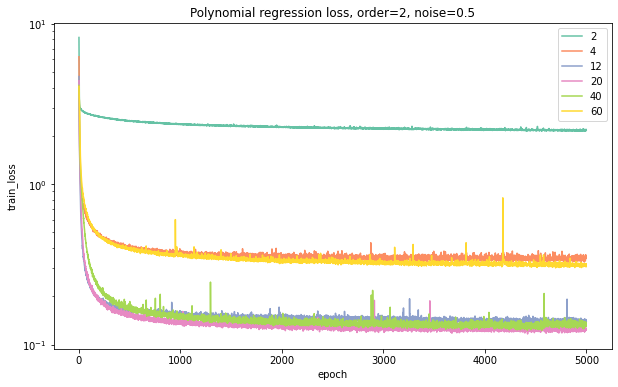

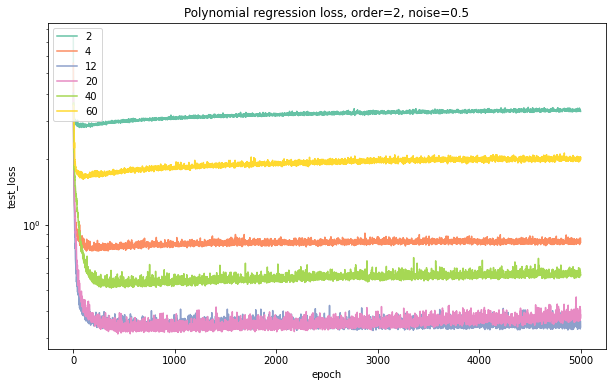

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_80_numexamples_50000_is_online_False_rep_1660448081.383974.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660480137.354691.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1660461795.745184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660473487.961765.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1660454205.619352.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660493174.530665.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_60_numexamples_50000_is_online_False_rep_1660505233.522593.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660486799.028931.pkl
/sc

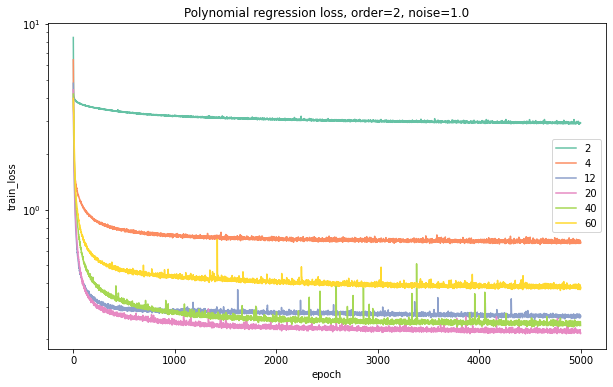

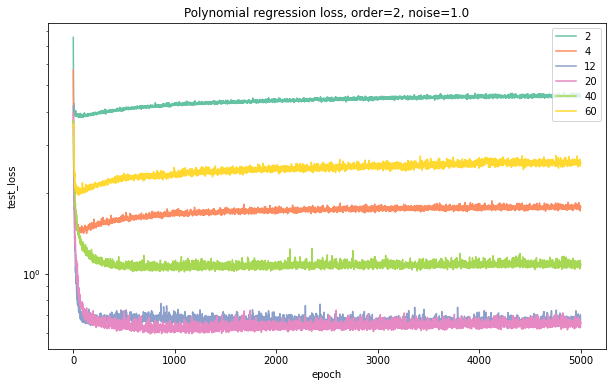

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1660587508.15507.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587616.633156.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660587508.236121.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587621.874653.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587621.883807.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587677.557184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587677.677067.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587628.913662.pkl
/scra

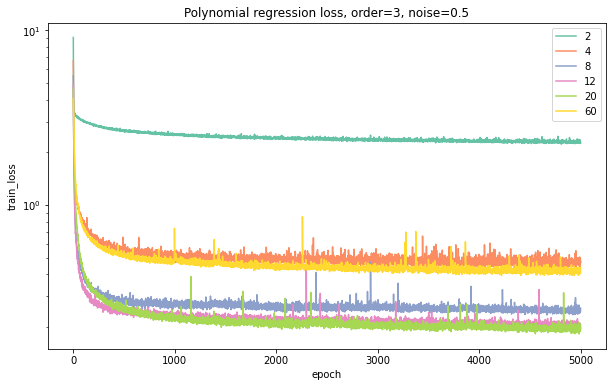

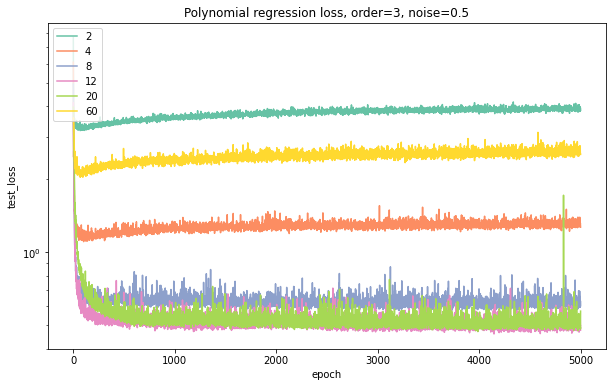

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1660587508.15507.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587616.633156.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660587508.236121.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587621.874653.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587621.883807.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587677.557184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587677.677067.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587628.913662.pkl
/scra

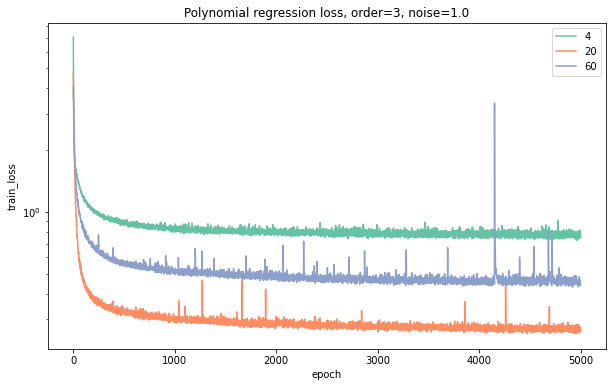

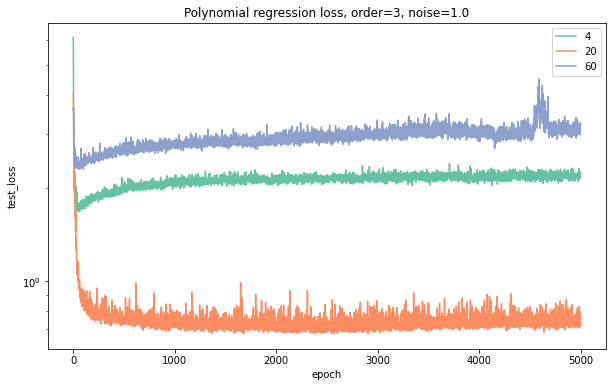

In [29]:
get_record(model_name = "mlp_small", order = 2, is_online=False, title = "Polynomial regression loss, order=2, noise=0.5", order_list=[2, 4,8,12,20, 40, 60], noise_list = [0.5], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 2, is_online=False, title = "Polynomial regression loss, order=2, noise=1.0", order_list=[2, 4,8,12,20, 40, 60], noise_list = [1.0], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 3, is_online=False, title = "Polynomial regression loss, order=3, noise=0.5", order_list=[2, 4,8,12,20, 40, 60], noise_list = [0.5], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 3, is_online=False, title = "Polynomial regression loss, order=3, noise=1.0", order_list=[2, 4,8,12,20, 40, 60], noise_list = [1.0], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
